In [17]:
print(__doc__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

Automatically created module for IPython interactive environment


In [18]:
# rng = np.random.RandomState(42)

In [62]:
train_df = pd.read_csv('dataset/imgs_2021070511352146227/trainset/messages_train.csv')
test_df = pd.read_csv('dataset/imgs_2021070511352146227/testset/messages_test.csv')

In [63]:
print(test_df)

      timeStamp                                               logs
0       5399328  ['systemd started session user cps', 'systemd ...
1       5399329  ['systemd started session user root', 'systemd...
2       5399330  ['systemd started session user root', 'systemd...
3       5399331  ['systemd started session user root', 'systemd...
4       5399332  ['systemd started session user root', 'systemd...
...         ...                                                ...
3145    5402491  ['systemd started session user cps', 'systemd ...
3146    5402492  ['systemd started session user cps', 'systemd ...
3147    5402493  ['systemd started session user cps', 'systemd ...
3148    5402494  ['systemd started session user cps', 'systemd ...
3149    5402495  ['systemd started session user root', 'systemd...

[3150 rows x 2 columns]


In [64]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['logs']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['logs']).split())
                                     for index, row in df_x.iterrows()]))

In [65]:
# Creating word vectors for trainset
doc2vec_tr = Doc2VecTransformer(vector_size=100)
doc2vec_tr.fit(train_df)
doc2vec_vectors = doc2vec_tr.transform(train_df)

100%|██████████| 14401/14401 [00:00<00:00, 1489278.86it/s]


In [66]:
# Generate train data
# X = 0.3 * rng.randn(100, 2)
# X_train = np.r_[X + 2, X - 2]
X_train = doc2vec_vectors


In [67]:
print(X_train.shape)

(14401, 100)


In [68]:
# Creating word vectors for testset
doc2vec_test = Doc2VecTransformer(vector_size=100)
doc2vec_test.fit(test_df)
doc2vec_test_vecs = doc2vec_test.transform(test_df)

100%|██████████| 3150/3150 [00:00<00:00, 1354527.13it/s]


In [69]:
# # Generate some regular novel observations
# X = 0.3 * rng.randn(20, 2)
# X_test = np.r_[X + 2, X - 2]
X_test = doc2vec_test_vecs

In [70]:
# Generate some abnormal novel observations
# X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

In [71]:
# fit the model
# clf = IsolationForest(max_samples=100, random_state=rng)
clf = IsolationForest(max_samples=100)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
#y_pred_outliers = clf.predict(X_outliers)

In [31]:
# # plot the line, the samples, and the nearest vectors to the plane
# xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
# Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# plt.title("IsolationForest")
# plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
#                  s=20, edgecolor='k')
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
#                  s=20, edgecolor='k')
# # c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
# #                 s=20, edgecolor='k')
# plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([b1, b2, c],
#            ["training observations",
#             "new regular observations", "new abnormal observations"],
#            loc="upper left")

In [72]:
test_score = clf.score_samples(X_test)

In [73]:
print(test_score[:10])

[-0.49881603 -0.49076915 -0.52495832 -0.48413824 -0.49180304 -0.49978776
 -0.48473893 -0.5032439  -0.50177077 -0.50460124]


In [74]:
train_score = clf.score_samples(X_train)

In [76]:
print(train_score[:10])

[-0.48406002 -0.51355239 -0.4934302  -0.48622249 -0.49636785 -0.49632552
 -0.50796897 -0.4868488  -0.4934302  -0.50231747]


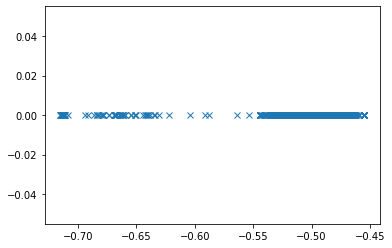

In [80]:
import numpy as np
import matplotlib.pyplot as pp
# this is the value where you want the data to appear on the y-axis.
ar = train_score # just as an example array
val = 0
pp.plot(ar, np.zeros_like(ar) + val, 'x')
pp.show()


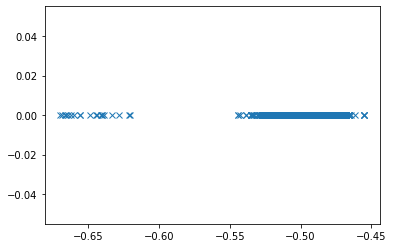

In [83]:
ar = test_score # just as an example array
val = 0
pp.plot(ar, np.zeros_like(ar) + val, 'x')
pp.show()

In [120]:
print(test_score[:10])

[-0.49881603 -0.49076915 -0.52495832 -0.48413824 -0.49180304 -0.49978776
 -0.48473893 -0.5032439  -0.50177077 -0.50460124]


In [116]:
x = list(test_score)

In [118]:
x.sort()

In [121]:
print(len(x))

3150
